In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderNotFound
import requests
from sklearn.preprocessing import MinMaxScaler
import os
import json
from sklearn.cluster import KMeans

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Population data for the state of Maine

Below is the population projection data for the state of Maine broken down by county. It shows population projects for the following years:
- 2016 (Observed)
- 2021
- 2026
- 2031
- 2036

The data is read directly from the website. Since the dataframe initially sets up a multilevel column index, we drop the top level and also rename column 0 to County since it is unnamed in the source data.

In [3]:
maine_data = pd.read_excel('https://www.maine.gov/dafs/economist/sites/maine.gov.dafs.economist/files/inline-files/MaineStateCountyPopulationProjections2036.xlsx', sheet_name='summary', header=[0, 1])
maine_data.columns = maine_data.columns.droplevel()
maine_data.rename(columns={ maine_data.columns[0]: "COUNTYNAME" }, 
                  inplace = True)
maine_data.head()

,COUNTYNAME,2016,2021,2026,2031,2036,2016-2021,2021-2026,2026-2031,2031-2036,2016-2036
0,Androscoggin,107269,107967.801439,108578.742776,108769.413854,108643.149064,0.006514,0.005659,0.001756,-0.001161,0.012810
1,Aroostook,68116,67928.772431,67735.738377,67337.098159,66857.364164,-0.002749,-0.002842,-0.005885,-0.007124,-0.018478
2,Cumberland,290905,294711.329744,298631.650980,301376.156664,302943.736659,0.013084,0.013302,0.009190,0.005201,0.041384
3,Franklin,30071,29963.778184,30029.549316,29967.173578,29772.523196,-0.003566,0.002195,-0.002077,-0.006495,-0.009926
4,Hancock,54398,54588.458399,54679.273561,54521.558330,54152.494022,0.003501,0.001664,-0.002884,-0.006769,-0.004513


# County latitude and longitude data for the state of Maine

The data below was downloaded from [weather.gov](https://www.weather.gov/gis/Counties) and contains the latitude and longtude for every county in the USA. Data is filtered to only account for the state of Maine, and the geometry column is dropped since we aren't concerned with the polygon data. These steps make it easier to work with the data.

In [4]:
gdf = geopandas.read_file('data\county_data_from_weather_gov\c_03mr20.shp')
gdf.drop(['geometry'], axis=1, inplace=True)
gdf.head()

,STATE,CWA,COUNTYNAME,FIPS,TIME_ZONE,FE_AREA,LON,LAT
0,ME,CAR,Washington,23029,E,se,-67.6361,45.0363
1,GA,CHS,McIntosh,13191,E,se,-81.2646,31.5329
2,GA,CHS,Liberty,13179,E,se,-81.2103,31.7093
3,AS,PPG,Swains Island,60040,S,None,-171.0459,-11.0843
4,AS,PPG,Manu'a,60020,S,None,-169.5060,-14.2219


In [5]:
gdf = gdf[gdf.STATE == "ME"]
gdf.head()

,STATE,CWA,COUNTYNAME,FIPS,TIME_ZONE,FE_AREA,LON,LAT
0,ME,CAR,Washington,23029,E,se,-67.6361,45.0363
264,ME,GYX,Androscoggin,23001,E,sw,-70.2045,44.1654
282,ME,GYX,Knox,23013,E,sc,-69.1730,44.1500
283,ME,GYX,Sagadahoc,23023,E,sc,-69.8613,43.9705
284,ME,GYX,Lincoln,23015,E,sc,-69.5431,44.0752


# Merge the dataframes

We need to combine the data into a single dataframe for ease of working with it. Since both dataframes have a COUNTYNAME column that should include unique values we will use that column as the merge point.

In [6]:
data_merged = maine_data.merge(gdf, on="COUNTYNAME", how = 'inner')
data_merged.head()

,COUNTYNAME,2016,2021,2026,2031,2036,2016-2021,2021-2026,2026-2031,2031-2036,2016-2036,STATE,CWA,FIPS,TIME_ZONE,FE_AREA,LON,LAT
0,Androscoggin,107269,107967.801439,108578.742776,108769.413854,108643.149064,0.006514,0.005659,0.001756,-0.001161,0.012810,ME,GYX,23001,E,sw,-70.2045,44.1654
1,Aroostook,68116,67928.772431,67735.738377,67337.098159,66857.364164,-0.002749,-0.002842,-0.005885,-0.007124,-0.018478,ME,CAR,23003,E,nn,-68.5988,46.6588
2,Cumberland,290905,294711.329744,298631.650980,301376.156664,302943.736659,0.013084,0.013302,0.009190,0.005201,0.041384,ME,GYX,23005,E,sw,-70.4096,43.8487
3,Franklin,30071,29963.778184,30029.549316,29967.173578,29772.523196,-0.003566,0.002195,-0.002077,-0.006495,-0.009926,ME,GYX,23007,E,ww,-70.4440,44.9740
4,Hancock,54398,54588.458399,54679.273561,54521.558330,54152.494022,0.003501,0.001664,-0.002884,-0.006769,-0.004513,ME,CAR,23009,E,se,-68.3531,44.6749


# Create map of Maine

We start by using geolocator to find the coordinates for the center of Maine to create our base map. Then we use the merged data to find the coordinates of the center of each county and we put a marker there with the county name and we make the bubble relfect a scaled representation of the change in population projected from 2016 through 2036.

This provides us our first analytic. The bubble doesn't show growth(loss) only a representation of the projected change in population. The label includes the county name and the information on projected population change.

In [7]:
state = 'Maine'
#we will use this location as center of our map
geolocater = Nominatim(user_agent="dummy-exp")
center = geolocater.geocode(state)
lat = center.latitude
lon = center.longitude
print('The geograpical coordinate of the center of {} is {}, {}.'.format(
    state, lat, lon))

The geograpical coordinate of the center of Maine is 45.709097, -68.8590201.


In [8]:
map_maine=folium.Map(location=[lat,lon],zoom_start=6)
for lat, long, area, delta_pop in zip(data_merged['LAT'], data_merged['LON'],
                                      data_merged['COUNTYNAME'],
                                      data_merged['2016-2036']):
    label = folium.Popup('{} County\nPopulation change through 2036: {:.2f}%'
                         .format(area, delta_pop*100), 
                         parse_html=True, 
                         max_width=325, 
                         min_width=325)
    folium.CircleMarker(
        [lat, long],
        radius=abs(delta_pop) * 250 / 2,
        popup=label,
        color='blue',
        fill=False,
        fill_color='blue',
        fill_opacity=1,
        parse_html=False).add_to(map_maine)
    
map_maine

# Foursquare data

Now that we have some interesting data regarding populaion change projections and the current state of COVID-19, we can explore some venue data from Foursquare.

Maine is heavily dependent on tourism for its economy and seeing where venues are, and how COVID-19 is affecting them currently, could lead us to help predict where we might want to setup more business opportunities to support the economy or pull the plug on businesses that might not fare well in the environment.

In [9]:
api_info = pd.read_csv(r'data\4SQ_API_KEYS.csv')
CID = api_info['CLIENT ID'].values[0]
CSEC = api_info['CLIENT SECRET'].values[0]
VER = '20200715'

In [10]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CID, 
            CSEC, 
            VER)
            
results = requests.get(categories_url).json()

print(results)

categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

{'meta': {'code': 200, 'requestId': '5f10b7aa722cee4edadef16f'}, 'response': {'categories': [{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment', 'pluralName': 'Arts & Entertainment', 'shortName': 'Arts & Entertainment', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': [{'id': '56aa371be4b08b9a8d5734db', 'name': 'Amphitheater', 'pluralName': 'Amphitheaters', 'shortName': 'Amphitheater', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_', 'suffix': '.png'}, 'categories': []}, {'id': '4fceea171983d5d06c3e9823', 'name': 'Aquarium', 'pluralName': 'Aquariums', 'shortName': 'Aquarium', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_', 'suffix': '.png'}, 'categories': []}, {'id': '4bf58dd8d48988d1e1931735', 'name': 'Arcade', 'pluralName': 'Arcades', 'shortName': 'Arcade', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/a

In [11]:
def get_venues_count(lat, long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}'.format(
                CID, 
                CSEC, 
                VER,
                lat,
                long,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

In [12]:
df_venues = data_merged.copy()
for c in categories_list:
    df_venues[c[0]] = 0
    
df_venues.head()

,COUNTYNAME,2016,2021,2026,2031,2036,2016-2021,2021-2026,2026-2031,2031-2036,2016-2036,STATE,CWA,FIPS,TIME_ZONE,FE_AREA,LON,LAT,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Androscoggin,107269,107967.801439,108578.742776,108769.413854,108643.149064,0.006514,0.005659,0.001756,-0.001161,0.012810,ME,GYX,23001,E,sw,-70.2045,44.1654,0,0,0,0,0,0,0,0,0,0
1,Aroostook,68116,67928.772431,67735.738377,67337.098159,66857.364164,-0.002749,-0.002842,-0.005885,-0.007124,-0.018478,ME,CAR,23003,E,nn,-68.5988,46.6588,0,0,0,0,0,0,0,0,0,0
2,Cumberland,290905,294711.329744,298631.650980,301376.156664,302943.736659,0.013084,0.013302,0.009190,0.005201,0.041384,ME,GYX,23005,E,sw,-70.4096,43.8487,0,0,0,0,0,0,0,0,0,0
3,Franklin,30071,29963.778184,30029.549316,29967.173578,29772.523196,-0.003566,0.002195,-0.002077,-0.006495,-0.009926,ME,GYX,23007,E,ww,-70.4440,44.9740,0,0,0,0,0,0,0,0,0,0
4,Hancock,54398,54588.458399,54679.273561,54521.558330,54152.494022,0.003501,0.001664,-0.002884,-0.006769,-0.004513,ME,CAR,23009,E,se,-68.3531,44.6749,0,0,0,0,0,0,0,0,0,0


In [13]:
for i, row in df_venues.iterrows():
    for c in categories_list:        
        df_venues.loc[i, c[0]] = get_venues_count(df_venues.iloc[i].LAT, 
                                                  df_venues.iloc[i].LON, 
                                                  radius=1000, categoryId=c[1])
        
    print('{} County ({}, {}) data gathering for is complete'.format(
        df_venues.iloc[i].COUNTYNAME, df_venues.iloc[i].LAT, 
        df_venues.iloc[i].LON))
    df_venues.to_csv(r'data\area_venues.csv')

Androscoggin County (44.1654, -70.2045) data gathering for is complete
Aroostook County (46.6588, -68.5988) data gathering for is complete
Cumberland County (43.8487, -70.4096) data gathering for is complete
Franklin County (44.974, -70.444) data gathering for is complete
Hancock County (44.6749, -68.3531) data gathering for is complete
Kennebec County (44.4093, -69.7672) data gathering for is complete
Knox County (44.15, -69.173) data gathering for is complete
Lincoln County (44.0752, -69.5431) data gathering for is complete
Oxford County (44.499, -70.7555) data gathering for is complete
Penobscot County (45.4006, -68.6494) data gathering for is complete
Piscataquis County (45.838, -69.2835) data gathering for is complete
Sagadahoc County (43.9705, -69.8613) data gathering for is complete
Somerset County (45.5138, -69.9582) data gathering for is complete
Waldo County (44.5037, -69.1478) data gathering for is complete
Washington County (45.0363, -67.6361) data gathering for is complete

In [14]:
df_venues=pd.read_csv(r'data\area_venues.csv', index_col=0)
df_venues.head()

,COUNTYNAME,2016,2021,2026,2031,2036,2016-2021,2021-2026,2026-2031,2031-2036,2016-2036,STATE,CWA,FIPS,TIME_ZONE,FE_AREA,LON,LAT,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Androscoggin,107269,107967.801439,108578.742776,108769.413854,108643.149064,0.006514,0.005659,0.001756,-0.001161,0.012810,ME,GYX,23001,E,sw,-70.2045,44.1654,14,39,5,87,12,56,148,9,200,23
1,Aroostook,68116,67928.772431,67735.738377,67337.098159,66857.364164,-0.002749,-0.002842,-0.005885,-0.007124,-0.018478,ME,CAR,23003,E,nn,-68.5988,46.6588,0,0,0,3,3,16,9,2,10,1
2,Cumberland,290905,294711.329744,298631.650980,301376.156664,302943.736659,0.013084,0.013302,0.009190,0.005201,0.041384,ME,GYX,23005,E,sw,-70.4096,43.8487,4,73,7,44,5,31,129,12,170,16
3,Franklin,30071,29963.778184,30029.549316,29967.173578,29772.523196,-0.003566,0.002195,-0.002077,-0.006495,-0.009926,ME,GYX,23007,E,ww,-70.4440,44.9740,9,1,1,31,11,4,15,4,38,13
4,Hancock,54398,54588.458399,54679.273561,54521.558330,54152.494022,0.003501,0.001664,-0.002884,-0.006769,-0.004513,ME,CAR,23009,E,se,-68.3531,44.6749,23,15,5,52,5,35,110,7,170,81


# Exploratory Data Analysis

Lets make a box plot for Venues

Normalize the data using MinMaxScaler (scale from 0 to 1). This scales the data and provides an easy to interpret score at the same time.

In [16]:
X = df_venues.values[:,18:]
scaled_dataset = MinMaxScaler().fit_transform(X)
df_scaled = pd.DataFrame(scaled_dataset)
df_scaled.columns = [c[0] for c in categories_list]
df_scaled.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.608696,0.534247,0.714286,1.000000,0.428571,0.928571,1.000000,0.375000,1.00,0.2750
1,0.000000,0.000000,0.000000,0.034483,0.107143,0.214286,0.047945,0.083333,0.05,0.0000
2,0.173913,1.000000,1.000000,0.505747,0.178571,0.482143,0.869863,0.500000,0.85,0.1875
3,0.391304,0.013699,0.142857,0.356322,0.392857,0.000000,0.089041,0.166667,0.19,0.1500
4,1.000000,0.205479,0.714286,0.597701,0.178571,0.553571,0.739726,0.291667,0.85,1.0000


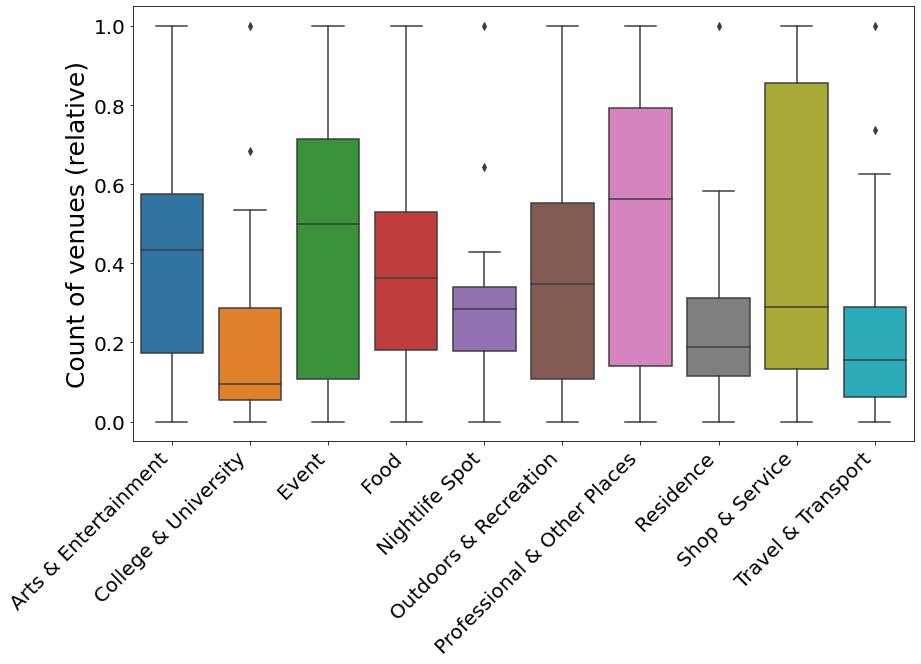

In [17]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(data = df_scaled)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [26]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_scaled)

kmeans_labels = kmeans.labels_

df_venues_clustered = df_venues.copy()
df_venues_clustered['Cluster'] = kmeans_labels

#dataframe to be used for box plot
df_scaled_clustered = df_scaled.copy()
df_scaled_clustered['Cluster'] = kmeans_labels

In [27]:
df_scaled_clustered.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster
0,0.608696,0.534247,0.714286,1.000000,0.428571,0.928571,1.000000,0.375000,1.00,0.2750,0
1,0.000000,0.000000,0.000000,0.034483,0.107143,0.214286,0.047945,0.083333,0.05,0.0000,1
2,0.173913,1.000000,1.000000,0.505747,0.178571,0.482143,0.869863,0.500000,0.85,0.1875,2
3,0.391304,0.013699,0.142857,0.356322,0.392857,0.000000,0.089041,0.166667,0.19,0.1500,1
4,1.000000,0.205479,0.714286,0.597701,0.178571,0.553571,0.739726,0.291667,0.85,1.0000,0


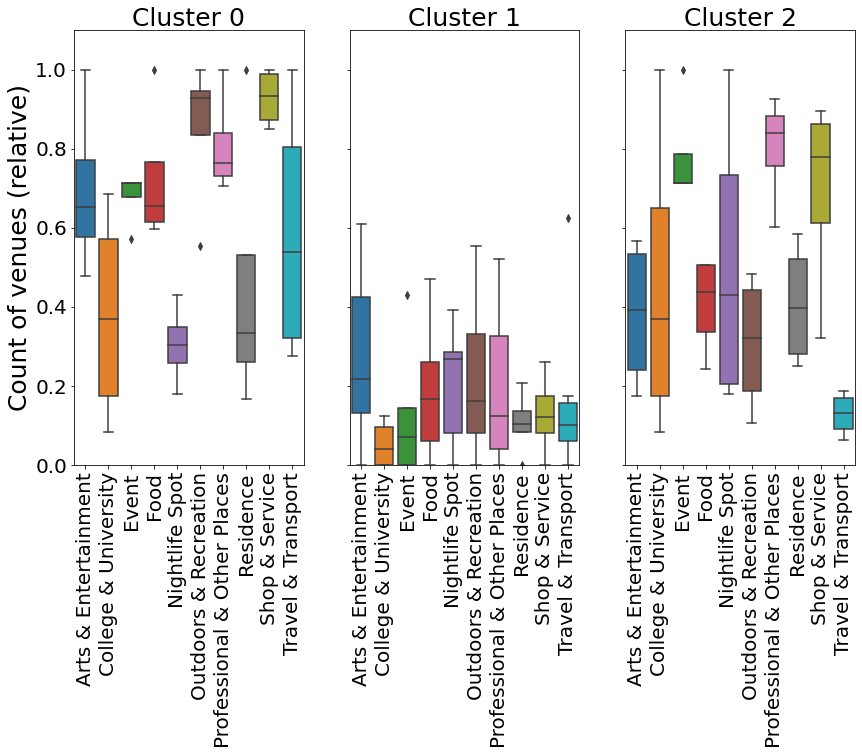

In [28]:
fig,axes= plt.subplots(1,kclusters,figsize=(14,8),sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_scaled_clustered[df_scaled_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [25]:
map_maine_cluster = folium.Map(location=[lat,lon],zoom_start=6)

#add markers
for i, lat, long, cluster in zip(df_venues_clustered.index,
                                         # df_venues_clustered['Area'],
                                         df_venues_clustered['LAT'],
                                         df_venues_clustered['LON'],
                                         df_venues_clustered['Cluster']):
    #colors = sns.color_palette(None, kclusters).as_hex()
    colors=['orange','green','red','yellow']
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        popup=folium.Popup('Cluster {}'.format(cluster), max_width=50, 
                         min_width=50),
        radius=6,
        color=colors[cluster]).add_to(map_maine_cluster)
    
map_maine_cluster

In [22]:
map_maine